In [ ]:
import fastai
fastai.__version__

'2.3.0'

In [ ]:
!pip install -U fastai

     |████████████████████████████████| 194kB 4.3MB/s 
     |████████████████████████████████| 776.8MB 22kB/s 
     |████████████████████████████████| 61kB 9.2MB/s 
     |████████████████████████████████| 12.8MB 58.7MB/s 
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.7.1 which is incompatible.
  Found existing installation: torch 1.8.1+cu101
    Uninstalling torch-1.8.1+cu101:
      Successfully uninstalled torch-1.8.1+cu101
  Found existing installation: torchvision 0.9.1+cu101
    Uninstalling torchvision-0.9.1+cu101:
      Successfully uninstalled torchvision-0.9.1+cu101
  Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61


In [ ]:
!pip install torchcam

In [ ]:
from torchvision.io.image import read_image
from torchvision.transforms.functional import normalize, resize, to_pil_image
from torchcam.cams import SmoothGradCAMpp
from torchcam.cams import SmoothGradCAMpp
import matplotlib.pyplot as plt
from torchcam.utils import overlay_mask

from sklearn.metrics import confusion_matrix, classification_report
import shutil
import os
from pathlib import Path
from fastai.vision.all import *

In [ ]:
def get_labels_and_preds(predictions):
  df = pd.DataFrame(predictions[0])
  preds = (df[0] < df[1]).astype(int)
  labels = predictions[1]
  return labels, preds

def visualize_cam_on_img(img_name, model):
  cam_extractor = SmoothGradCAMpp(model)
  # Get your input
  img = read_image(str(img_name))

  # Preprocess it for your chosen model
  input_tensor = normalize(resize(img, (224, 224)) / 255., [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]).cuda()

  # Preprocess your data and feed it to the model
  out = model(input_tensor.unsqueeze(0))
  # Retrieve the CAM by passing the class index and the model output
  activation_map = cam_extractor(out.squeeze(0).argmax().item(), out)


  # Resize the CAM and overlay it
  result = overlay_mask(to_pil_image(img), to_pil_image(activation_map, mode='F'), alpha=0.5)
  # Display it
  plt.imshow(result); plt.axis('off'); plt.tight_layout(); plt.show()

def rename_in_order(folder):
    files = list(folder.glob("*"))
    temp_folder = folder / "temp"
    temp_folder.mkdir()
    target_files = []
    for i in range(len(files)):
        source = files[i]
        target = temp_folder / f"{i+1:03}.jpg"
        target_files.append(target)
        shutil.move(source, target)
    for file in target_files:
        shutil.copy2(file, folder)
    shutil.rmtree(temp_folder)

def init_images_dir(images):
  if images.exists():
    shutil.rmtree(images)

  images.mkdir()

  train_folder = images / "train"
  valid_folder = images / "valid"
  test_folder = images / "test"

  train_folder.mkdir()
  valid_folder.mkdir()
  test_folder.mkdir()

def split_images_into_train_valid_test(mycls, images, images_original, train_ratio=0.7, test_ratio=0.1):

    # cls_images = images_original / mycls
    files = list((images_original / mycls).glob("*.jpg"))

    train_length = round(len(files) * train_ratio)
    test_length = round(len(files) * test_ratio)

    train = files[:train_length]
    valid = files[train_length:len(files) - test_length]
    test = files[len(files) - test_length:]

    train_folder = images / "train"
    valid_folder = images / "valid"
    test_folder = images / "test"

    (train_folder / mycls).mkdir()
    (valid_folder / mycls).mkdir()
    (test_folder / mycls).mkdir()

    for file in train:
        shutil.copy(file, train_folder / mycls)

    for file in valid:
        shutil.copy(file, valid_folder / mycls)

    for file in test:
        shutil.copy(file, test_folder / mycls)
        
    rename_in_order(train_folder / mycls)
    rename_in_order(valid_folder / mycls)
    rename_in_order(test_folder / mycls)

In [ ]:
!git clone https://github.com/wshuyi/big-cats-image-original.git

Cloning into 'big-cats-image-original'...
remote: Enumerating objects: 453, done.
remote: Counting objects: 100% (453/453), done.
remote: Compressing objects: 100% (452/452), done.
remote: Total 453 (delta 0), reused 449 (delta 0), pack-reused 0
Receiving objects: 100% (453/453), 75.67 MiB | 24.50 MiB/s, done.


In [ ]:
# make targets

In [ ]:
images = Path('images')

In [ ]:
init_images_dir(images)

In [ ]:
images_original = Path("big-cats-image-original/")

In [ ]:
for mycls in ["cheetah", "jaguar"]:
  split_images_into_train_valid_test(mycls, images, images_original)

In [ ]:
len(list(images.glob("*/*/*.jpg")))

300

In [ ]:
arch = resnet18
# run_date = "20210418"
metrics=[accuracy, error_rate]
item_tfms=Resize(224)
batch_tfms=aug_transforms()
seed=2
epochs = 20


In [ ]:
working_dir = Path(".")

In [ ]:
dls = ImageDataLoaders.from_folder(images, train='train', valid='valid', seed=seed, item_tfms=item_tfms, batch_tfms=batch_tfms)

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


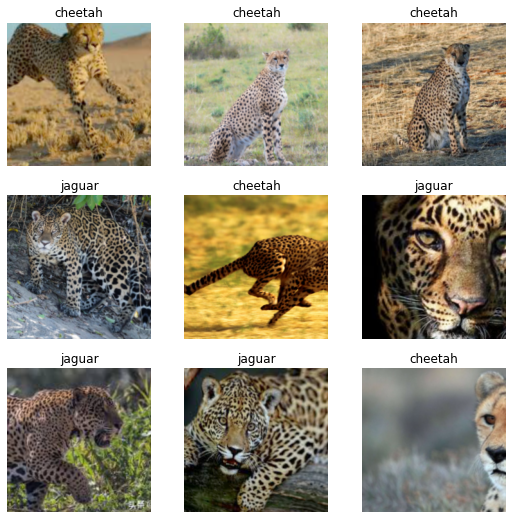

In [ ]:
dls.show_batch()

In [ ]:
learn = cnn_learner(dls, arch, metrics=metrics)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [ ]:
# learn.lr_find()

In [ ]:
base_lr = 3e-3

In [ ]:
%%time
# log_fname = working_dir/f'history-{run_date}-{arch}.csv'
# learn.fine_tune(epochs=epochs, base_lr=base_lr, cbs=[CSVLogger(fname=log_fname), SaveModelCallback(), EarlyStoppingCallback()])
learn.fine_tune(epochs=epochs, base_lr=base_lr, cbs=[SaveModelCallback(), EarlyStoppingCallback()])

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.862040,0.103327,0.966667,0.033333,00:04


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Better model found at epoch 0 with valid_loss value: 0.1033267080783844.


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.242023,0.042955,0.983333,0.016667,00:04
1,0.187914,0.008394,1.000000,0.000000,00:04
2,0.150139,0.001233,1.000000,0.000000,00:03
3,0.129825,0.000300,1.000000,0.000000,00:03
4,0.107355,0.000065,1.000000,0.000000,00:03
5,0.088189,0.000032,1.000000,0.000000,00:03
6,0.076552,0.000031,1.000000,0.000000,00:03
7,0.065648,0.000018,1.000000,0.000000,00:04
8,0.060486,0.000027,1.000000,0.000000,00:03


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Better model found at epoch 0 with valid_loss value: 0.0429554209113121.


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Better model found at epoch 1 with valid_loss value: 0.008394092321395874.


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Better model found at epoch 2 with valid_loss value: 0.0012327778385952115.


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Better model found at epoch 3 with valid_loss value: 0.00030035804957151413.


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Better model found at epoch 4 with valid_loss value: 6.53414535918273e-05.


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Better model found at epoch 5 with valid_loss value: 3.2491330784978345e-05.


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Better model found at epoch 6 with valid_loss value: 3.1228970328811556e-05.


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Better model found at epoch 7 with valid_loss value: 1.8084141629515216e-05.


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


No improvement since epoch 7: early stopping
CPU times: user 3.36 s, sys: 3.87 s, total: 7.23 s
Wall time: 40.9 s


In [ ]:
model_dump = working_dir/ f"fine_tuned"

In [ ]:
learn.save(model_dump)

Path('images/models/fine_tuned.pth')

In [ ]:
dls1 = ImageDataLoaders.from_folder(images, train='train', valid='test', seed=seed, item_tfms=item_tfms)

In [ ]:
learn1 = cnn_learner(dls1, arch, metrics=metrics)

In [ ]:
learn1.load(model_dump)

In [ ]:
%%time
predictions = learn1.get_preds()

CPU times: user 65.4 ms, sys: 156 ms, total: 222 ms
Wall time: 1.03 s


In [ ]:
predictions

(tensor([[9.7036e-01, 2.9639e-02],
         [9.9191e-01, 8.0900e-03],
         [1.0000e+00, 1.3984e-08],
         [1.0000e+00, 4.3579e-06],
         [1.0000e+00, 7.0574e-09],
         [1.0000e+00, 7.5029e-10],
         [1.0000e+00, 1.5629e-07],
         [1.0000e+00, 1.5872e-07],
         [9.9999e-01, 5.0413e-06],
         [1.0000e+00, 7.6841e-07],
         [1.0000e+00, 9.0795e-07],
         [1.0000e+00, 1.3112e-06],
         [1.0000e+00, 1.7709e-06],
         [1.0000e+00, 1.6937e-06],
         [1.0000e+00, 6.4888e-08],
         [8.8204e-09, 1.0000e+00],
         [1.4487e-12, 1.0000e+00],
         [2.7486e-13, 1.0000e+00],
         [1.2790e-11, 1.0000e+00],
         [4.6012e-11, 1.0000e+00],
         [6.5237e-09, 1.0000e+00],
         [1.1650e-09, 1.0000e+00],
         [6.5664e-12, 1.0000e+00],
         [2.7944e-10, 1.0000e+00],
         [4.0544e-09, 1.0000e+00],
         [2.5012e-08, 1.0000e+00],
         [1.4388e-09, 1.0000e+00],
         [2.3132e-08, 1.0000e+00],
         [5.7533e-06

In [ ]:
labels, preds = get_labels_and_preds(predictions)

In [ ]:
print(classification_report(labels, preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       1.00      1.00      1.00        15

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



In [ ]:
print(confusion_matrix(labels, preds))

[[15  0]
 [ 0 15]]


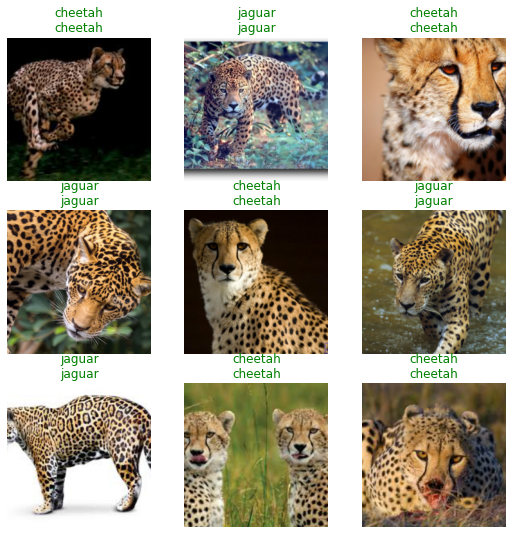

In [ ]:
learn1.show_results()

In [ ]:
interp = Interpretation.from_learner(learn1)

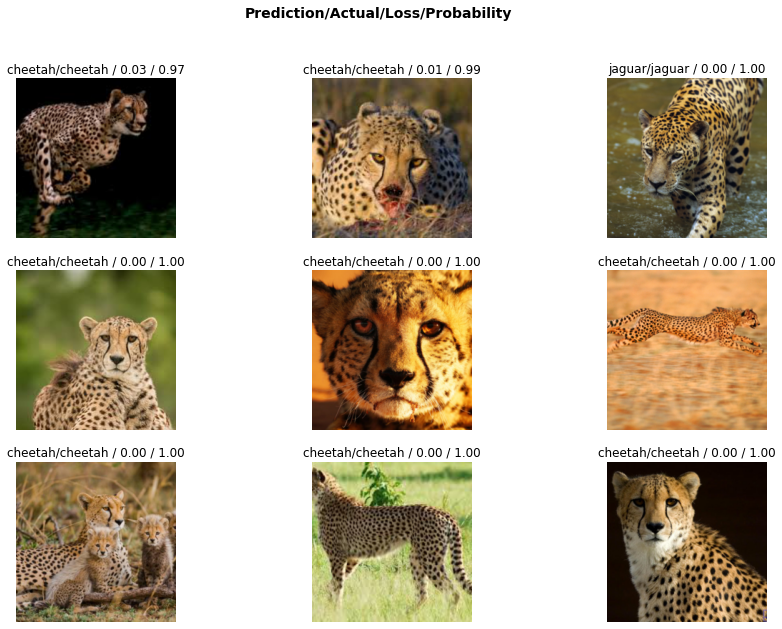

In [ ]:
interp.plot_top_losses(9, figsize=(15,10))


In [ ]:
#Visualize the arch

In [ ]:
dummy_input = torch.randn(2, 3, 224, 224).cuda()

In [ ]:
torch.onnx.export(learn1.model, dummy_input, "output.onnx", verbose=False)

In [ ]:
model = learn1.model

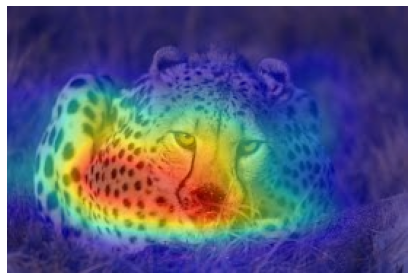

In [ ]:
img_name = images/"test/cheetah/001.jpg"
visualize_cam_on_img(img_name, model)

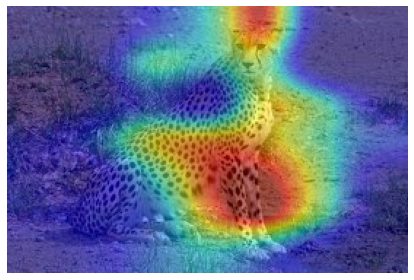

In [ ]:
img_name = images/"test/cheetah/015.jpg"
visualize_cam_on_img(img_name, model)

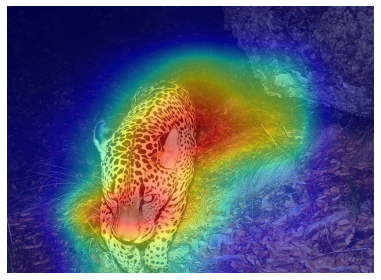

In [ ]:
img_name = images/"test/jaguar/001.jpg"
visualize_cam_on_img(img_name, model)

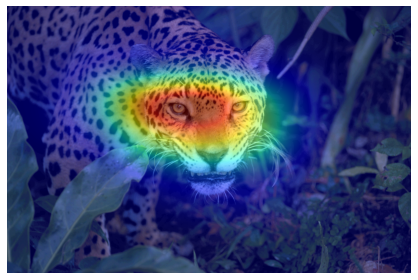

In [ ]:
img_name = images/"test/jaguar/015.jpg"
visualize_cam_on_img(img_name, model)